In [1]:
import pandas as pd
from torch.utils.data import DataLoader,Dataset, Subset
import numpy as np
import tft_model
from data_formatters import ts_dataset  
import data_formatters.base
import expt_settings.configs
import importlib
from data_formatters import utils
import torch.optim as optim


In [2]:
pd.set_option('max_columns', 1000)

In [3]:
importlib.reload(tft_model)
importlib.reload(utils)

<module 'data_formatters.utils' from '/Users/ardakeskiner/Desktop/TUM/Courses/ws19_20/Temporal_Fusion_Transform/data_formatters/utils.py'>

In [4]:
ExperimentConfig = expt_settings.configs.ExperimentConfig

config = ExperimentConfig('electricity', 'outputs')
data_formatter = config.make_data_formatter()


print("*** Training from defined parameters for {} ***".format('electricity'))
data_csv_path = 'data/hourly_electricity.csv'
print("Loading & splitting data...")
raw_data = pd.read_csv(data_csv_path, index_col=0)
train, valid, test = data_formatter.split_data(raw_data)
train_samples, valid_samples = data_formatter.get_num_samples_for_calibration(
)

# Sets up default params
fixed_params = data_formatter.get_experiment_params()
params = data_formatter.get_default_model_params()

*** Training from defined parameters for electricity ***
Loading & splitting data...


/Users/ardakeskiner/anaconda3/envs/thesis/lib/python3.6/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Formatting train-valid-test splits.
Setting scalers with training data...


In [7]:
len(train.id.unique())

369

In [5]:
id_col = 'categorical_id'
time_col='hours_from_start'
input_cols =['power_usage', 'hour', 'day_of_week', 'hours_from_start', 'categorical_id']
static_cols = ['categorical_id']
target_col = 'power_usage'
time_steps=192
num_encoder_steps = 168
output_size = 1
max_samples = 1000
input_size = 5

elect = ts_dataset.TSDataset(id_col, static_cols, time_col, input_cols,
                      target_col, time_steps, max_samples,
                     input_size, num_encoder_steps, output_size, train)

Getting valid sampling locations.
Extracting 1000 samples...


In [6]:
batch_size=64
loader = DataLoader(
            elect,
            batch_size=batch_size,
            num_workers=2,
            shuffle=True
        )

In [7]:
for batch in loader:
    break

In [8]:
static_cols = ['meter']
categorical_cols = ['hour']
real_cols = ['power_usage','hour', 'day']
config = {}
config['static_variables'] = len(static_cols)
config['time_varying_categoical_variables'] = 1
config['time_varying_real_variables_encoder'] = 4
config['time_varying_real_variables_decoder'] = 3
config['num_masked_series'] = 1
config['static_embedding_vocab_sizes'] = [369]
config['time_varying_embedding_vocab_sizes'] = [369]
config['embedding_dim'] = 8
config['lstm_hidden_dimension'] = 160
config['lstm_layers'] = 1
config['dropout'] = 0.05
config['device'] = 'cpu'
config['batch_size'] = 64
config['encode_length'] = 168
config['attn_heads'] = 4
config['num_quantiles'] = 3
config['vailid_quantiles'] = [0.1,0.5,0.9]
config['seq_length'] = 192

In [10]:
model = tft_model.TFT(config)


/Users/ardakeskiner/anaconda3/envs/thesis/lib/python3.6/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.05 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [11]:
output,encoder_output, decoder_output, attn_output, attn_output_weights, encoder_sparse_weights, decoder_sparse_weights = model.forward(batch)

/Users/ardakeskiner/Desktop/TUM/Courses/ws19_20/Temporal_Fusion_Transform/tft_model.py:172: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sparse_weights = self.softmax(sparse_weights).unsqueeze(2)


In [12]:
output.shape

torch.Size([64, 24, 3])

In [13]:
q_loss_func = tft_model.QuantileLoss([0.1,0.5,0.9])

In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.train()
epochs=50
losses = []
for i in range(epochs):
    epoch_loss = [] 
    j=0
    for batch in loader:
        output,encoder_output, decoder_output, attn_output, attn_output_weights, encoder_sparse_weights, decoder_sparse_weights = model(batch)
        loss= q_loss_func(output[:,:,:].view(-1,3), batch['outputs'][:,:,0].flatten().float())
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        j+=1
        if j>5:
            break
    losses.append(np.mean(epoch_loss))
    print(np.mean(epoch_loss))
    

1.0356486439704895
1.0082460641860962
1.0430258810520172
1.083491285641988
0.9917389651139578
1.0108490387598674
0.9417437811692556
0.9596185286839803
0.989658405383428
0.9606767992178599


In [18]:
output,encoder_output, decoder_output, attn_output, attn_output_weights, encoder_sparse_weights, decoder_sparse_weights = model(batch)


40


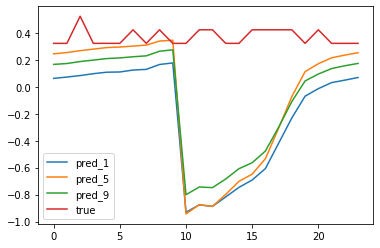

In [19]:
import matplotlib.pyplot as plt
import numpy as np

ind = np.random.choice(64)
print(ind)
plt.plot(output[ind,:,0].detach().cpu().numpy(), label='pred_1')
plt.plot(output[ind,:,1].detach().cpu().numpy(), label='pred_5')
plt.plot(output[ind,:,2].detach().cpu().numpy(), label='pred_9')

plt.plot(batch['outputs'][ind,:,0], label='true')
plt.legend()

In [224]:
attn_weights.shape

torch.Size([64, 192, 192])

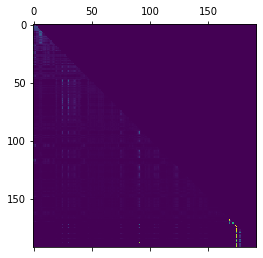

In [225]:
plt.matshow(attn_weights.detach().numpy()[0,:,:])

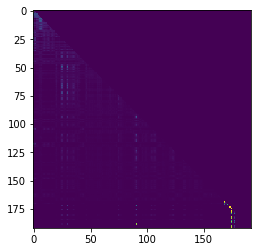

In [226]:
plt.imshow(attn_weights.detach().numpy()[0,:,:])